## Recommender system using Deep learning
* He, X., Liao, L., Zhang, H., Nie, L., Hu, X., & Chua, T. S. (2017, April). Neural collaborative filtering. In Proceedings of the 26th international conference on world wide web (pp. 173-182).
* Zhang, S., Yao, L., Sun, A., & Tay, Y. (2019). Deep learning based recommender system: A survey and new perspectives. ACM Computing Surveys (CSUR), 52(1), 1-38.
* Hidden layer가 없는 Neural network 는 Matrix Factorization 과 같은 모형이라고 할 수 있다.




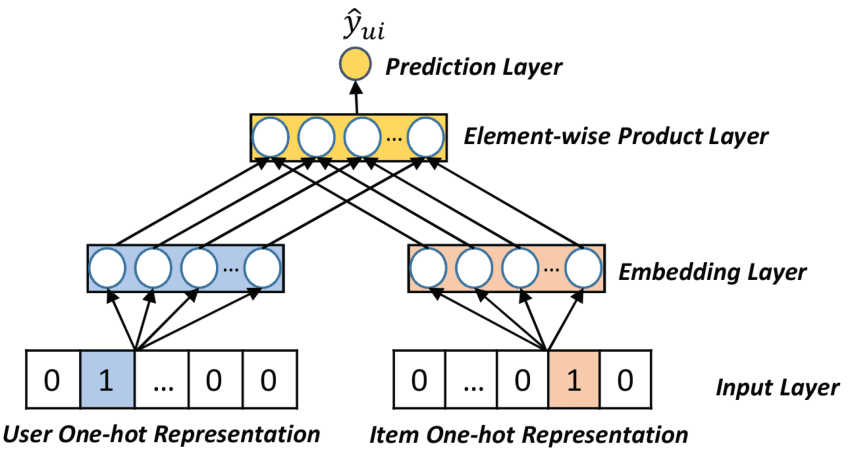

* 위 그림의 one-hot representation 에서 1의 값을 가지는 data는 rating matrix 상에서 user2 와 n-1번째 item (item이 n개 일 때)일 때의 data이다.
* Embedding layer는 Matrix Factorization 에서 잠재요인 K 에 해당하는 부분이다. 각 node는 하나의 잠재요인을 나타낸다. 모든 input feature는 embedding layer의 모든 node와 연결되어 있다. (하나의 node에 k개씩의 연결이 활성화됨)
* Element-wise product layer는 user, item embedding의 내적(dot product) 연산을 위한 layer이다. 위 그림의 계산 결과로 도출되는 값은 M x N rating matrix 상에서 (2, n-1)에 해당하는 값이 된다.

* 그림에 표현된 것 외에 추가로 고려해야할 요인은 MF에서의 user, item에 대한 bias 이다. 이는 MF에서의 분해 행렬 P, Q를 embedding layer로 변환한 것과 마찬가지로 user bias, item bias는 각각 하나의 node를 갖는 layer로 표현할 수 있다.

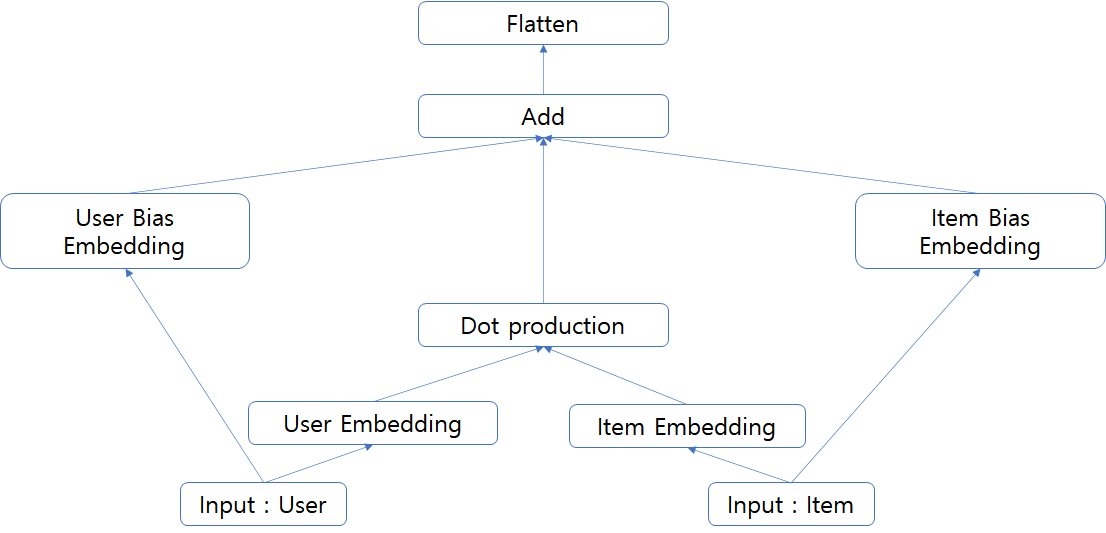

* MF 의 전체 수식과 비교해 볼 때 전체 평균 (mu)에 대한 term 이 빠져있는데 이는 모델에 직접 넣는 것보다 데이터를 신경망에 직접 넣는 것보다 전체 평균을 일률적으로 빼서 투입하고 산출된 예측치에 더해주는게 더 효율적이다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_repo = '/content/drive/MyDrive/recommender_system/practice/'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Mounted at /content/drive


In [ ]:
r_cols = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_csv(data_repo+'u.data', sep='\t', names = r_cols, encoding='latin-1')
ratings = ratings[['user_id','movie_id','rating']]

In [ ]:
from sklearn.model_selection import train_test_split
def train_test_rating(rating_matrix,random_seed = 42):
    x= rating_matrix.copy()
    y= rating_matrix['user_id']
    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = .25, stratify = y, random_state = random_seed)
    cold_start = X_test.loc[~X_test['movie_id'].isin(X_train['movie_id'].unique()), 'movie_id']
    X_train = X_train.append(X_test.loc[X_test['movie_id'].isin(cold_start.values), :])
    X_test = X_test.drop(cold_start.index)
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_rating(ratings)
print(X_train.shape, X_test.shape) 

(75058, 3) (24942, 3)


In [ ]:
X_train.head()

,user_id,movie_id,rating
56036,655,1005,4
48742,718,689,4
63175,561,675,3
65873,715,24,3
57711,567,32,5


In [ ]:
X_test.head()

,user_id,movie_id,rating
82476,878,179,4
74997,705,69,3
51890,467,475,4
28499,236,151,2
91205,471,1219,4


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [ ]:
K= 250
mu = X_train.rating.mean()
M = ratings.user_id.max() + 1
N = ratings.movie_id.max() +1

In [ ]:
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true-y_pred)))

def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))

In [ ]:
user = Input(shape=(1,))
item = Input(shape=(1,))
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N,K, embeddings_regularizer=l2())(item)
user_bias = Embedding(M,1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N,1, embeddings_regularizer=l2())(item)

R = layers.dot([P_embedding, Q_embedding], axes = 2)
R = layers.add([R, item_bias, user_bias])
R = Flatten()(R)

In [ ]:
model = Model(inputs=[user, item], outputs = R)
model.compile(loss = RMSE, optimizer = Adam(learning_rate=1e-4), metrics = [RMSE])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 200)       188800      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 200)       336600      input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
result = model.fit(x = [X_train.user_id.values, X_train.movie_id.values], y=X_train.rating.values - mu,
                   epochs=60, batch_size = 256, validation_data = ([X_test.user_id.values, X_test.movie_id.values], X_test.rating.values - mu)
                   )

Epoch 1/60
294/294 [==============================] - 5s 7ms/step - loss: 4.1210 - RMSE: 1.1280 - val_loss: 1.7535 - val_RMSE: 1.1214
Epoch 2/60
294/294 [==============================] - 2s 6ms/step - loss: 1.5206 - RMSE: 1.1176 - val_loss: 1.1789 - val_RMSE: 1.1176
Epoch 3/60
294/294 [==============================] - 2s 6ms/step - loss: 1.1542 - RMSE: 1.1168 - val_loss: 1.1221 - val_RMSE: 1.1146
Epoch 4/60
294/294 [==============================] - 2s 6ms/step - loss: 1.1176 - RMSE: 1.1116 - val_loss: 1.1170 - val_RMSE: 1.1121
Epoch 5/60
294/294 [==============================] - 2s 6ms/step - loss: 1.1135 - RMSE: 1.1086 - val_loss: 1.1154 - val_RMSE: 1.1100
Epoch 6/60
294/294 [==============================] - 2s 6ms/step - loss: 1.1123 - RMSE: 1.1069 - val_loss: 1.1144 - val_RMSE: 1.1083
Epoch 7/60
294/294 [==============================] - 2s 6ms/step - loss: 1.1135 - RMSE: 1.1073 - val_loss: 1.1137 - val_RMSE: 1.1068
Epoch 8/60
294/294 [==============================] - 2s 6ms/s

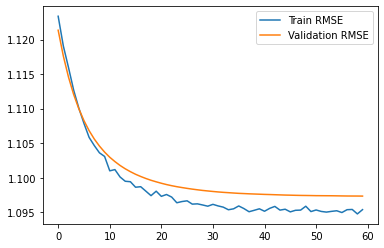

In [ ]:

plt.plot(result.history['RMSE'], label = 'Train RMSE')
plt.plot(result.history['val_RMSE'], label = 'Validation RMSE')
plt.legend()
plt.show()

In [ ]:
# predict score
user_ids = X_test.user_id.values[0:6]
movie_ids = X_test.movie_id.values[0:6]
y_preds = model.predict([user_ids, movie_ids]) + mu
print("Real score === \n", X_test.head(6))
print("prediction === \n", y_preds)

Real score === 
        user_id  movie_id  rating
82476      878       179       4
74997      705        69       3
51890      467       475       4
28499      236       151       2
91205      471      1219       4
39144      465       478       4


NameError: ignored

In [ ]:
model.evaluate([X_test.user_id.values, X_test.movie_id.values], X_test.rating.values - mu)

In [ ]:
y_preds = model.predict([X_test.user_id.values, X_test.movie_id.values]) + mu
y_preds = np.ravel(y_preds, order ='C')
y_true = np.array(X_test.rating)
RMSE2(y_true, y_preds)

### Exercise 1
* learning rate, # of batch_size, # of epochs 를 바꿔서 성능을 개선시켜보자

In [ ]:
K=256

from tensorflow.keras.callbacks import EarlyStopping
initial_learning_rate = 0.0015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=50000,
    decay_rate=0.96,
    staircase=True)

optimizer_ = tf.keras.optimizers.Adamax(learning_rate=lr_schedule)
nb_batch = 128
nb_epochs = 256
es = EarlyStopping(monitor='val_RMSE', mode='min', verbose=1,patience=16)

In [ ]:
def get_model():
    user = Input(shape=(1,))
    item = Input(shape=(1,))
    P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
    Q_embedding = Embedding(N,K, embeddings_regularizer=l2())(item)
    user_bias = Embedding(M,1, embeddings_regularizer=l2())(user)
    item_bias = Embedding(N,1, embeddings_regularizer=l2())(item)

    R = layers.dot([P_embedding, Q_embedding], axes = 2)
    R = layers.add([R, item_bias, user_bias])
    R = Flatten()(R)
    model = Model(inputs=[user, item], outputs = R)
    model.compile(loss = RMSE, optimizer = optimizer_, metrics = [RMSE])
    return model

In [ ]:
model = get_model()

In [ ]:
result = model.fit(x = [X_train.user_id.values, X_train.movie_id.values], y=X_train.rating.values - mu,
                   epochs=nb_epochs, 
                   batch_size = nb_batch, 
                   validation_data = ([X_test.user_id.values, X_test.movie_id.values], X_test.rating.values - mu),
                   callbacks = [es]
                   )

Epoch 1/256
587/587 [==============================] - 5s 7ms/step - loss: 1.6059 - RMSE: 1.1172 - val_loss: 1.1132 - val_RMSE: 1.1074
Epoch 2/256
587/587 [==============================] - 4s 6ms/step - loss: 1.1129 - RMSE: 1.1061 - val_loss: 1.1110 - val_RMSE: 1.1017
Epoch 3/256
587/587 [==============================] - 4s 7ms/step - loss: 1.1081 - RMSE: 1.0981 - val_loss: 1.1107 - val_RMSE: 1.0993
Epoch 4/256
587/587 [==============================] - 4s 7ms/step - loss: 1.1075 - RMSE: 1.0958 - val_loss: 1.1106 - val_RMSE: 1.0981
Epoch 5/256
587/587 [==============================] - 4s 7ms/step - loss: 1.1074 - RMSE: 1.0948 - val_loss: 1.1105 - val_RMSE: 1.0974
Epoch 6/256
587/587 [==============================] - 4s 6ms/step - loss: 1.1149 - RMSE: 1.1017 - val_loss: 1.1106 - val_RMSE: 1.0971
Epoch 7/256
587/587 [==============================] - 4s 7ms/step - loss: 1.1063 - RMSE: 1.0928 - val_loss: 1.1106 - val_RMSE: 1.0970
Epoch 8/256
587/587 [==============================] - 

In [ ]:
y_preds = model.predict([X_test.user_id.values, X_test.movie_id.values]) + mu
y_preds = np.ravel(y_preds, order ='C')
y_true = np.array(X_test.rating)
RMSE2(y_true, y_preds)

1.0984253183443433

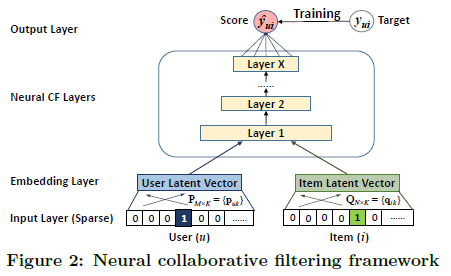

* 기존의 MF를 신경망으로 구현한 구조에서 Hidden layer를 추가해 복잡한 패턴을 학습하도록 함

In [ ]:
def get_nn_model():
    user = Input(shape=(1,))
    item = Input(shape=(1,))
    P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
    Q_embedding = Embedding(N,K, embeddings_regularizer=l2())(item)
    user_bias = Embedding(M,1, embeddings_regularizer=l2())(user)
    item_bias = Embedding(N,1, embeddings_regularizer=l2())(item)

    P_embedding = layers.Flatten()(P_embedding)
    Q_embedding = layers.Flatten()(Q_embedding)
    user_bias = Flatten()(user_bias)
    item_bias = Flatten()(item_bias)

    R = layers.Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])
    R = layers.Dense(2048, kernel_initializer='he_normal')(R)
    R = layers.Dense(256, kernel_initializer='he_normal')(R)
    R = layers.Dense(1)(R)
    model = Model(inputs=[user, item], outputs = R)
    model.compile(loss = RMSE, optimizer = optimizer_, metrics = [RMSE])
    return model

In [ ]:
nn_model = get_nn_model()

In [ ]:
result = nn_model.fit(x = [X_train.user_id.values, X_train.movie_id.values], y=X_train.rating.values - mu,
                   epochs=nb_epochs, 
                   batch_size = nb_batch, 
                   validation_data = ([X_test.user_id.values, X_test.movie_id.values], X_test.rating.values - mu),
                   callbacks = [es]
                   )

Epoch 1/256
587/587 [==============================] - 6s 8ms/step - loss: 1.9345 - RMSE: 1.0159 - val_loss: 1.0525 - val_RMSE: 0.9739
Epoch 2/256
587/587 [==============================] - 5s 8ms/step - loss: 1.0155 - RMSE: 0.9531 - val_loss: 0.9978 - val_RMSE: 0.9604
Epoch 3/256
587/587 [==============================] - 5s 8ms/step - loss: 0.9815 - RMSE: 0.9453 - val_loss: 0.9856 - val_RMSE: 0.9543
Epoch 4/256
587/587 [==============================] - 5s 8ms/step - loss: 0.9659 - RMSE: 0.9358 - val_loss: 0.9842 - val_RMSE: 0.9568
Epoch 5/256
587/587 [==============================] - 5s 8ms/step - loss: 0.9577 - RMSE: 0.9298 - val_loss: 0.9746 - val_RMSE: 0.9510
Epoch 6/256
587/587 [==============================] - 5s 8ms/step - loss: 0.9571 - RMSE: 0.9324 - val_loss: 0.9743 - val_RMSE: 0.9505
Epoch 7/256
587/587 [==============================] - 5s 8ms/step - loss: 0.9545 - RMSE: 0.9306 - val_loss: 0.9740 - val_RMSE: 0.9509
Epoch 8/256
587/587 [==============================] - 

In [ ]:
y_preds = nn_model.predict([X_test.user_id.values, X_test.movie_id.values]) + mu
y_preds = np.ravel(y_preds, order ='C')
y_true = np.array(X_test.rating)
RMSE2(y_true, y_preds)

0.949647049082344

* 딥러닝 모델은 입력으로 다양한 변수를 추가할 수 있다.
* 예를 들어 사용자와 아이템이, 다양한 특성을 포함시킬 수 있는데, 사용자의 나이, 성별, 직업과 같은 변수를 활용할 수 있을 것이다. (만약 직업 별로 영화 평점의 분포가 다르다면 예측력이 향상될 가능성이 있다)

In [ ]:
u_cols = ['user_id', 'age', 'sex','occupation', 'zip_code']
users = pd.read_csv(data_repo+'u.user', sep='|', names = u_cols, encoding = 'latin-1')

i_cols = ['movie_id', 'title', 'release_date', ' video_release_date', 'IMDB_URL', 'unknown',
          'Action','Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary',
          'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romane', 'Sci-FI',
          'Thriller', 'War', 'Western']
movies = pd.read_csv(data_repo+'u.item', sep='|', names= i_cols, encoding='latin-1')

In [ ]:
occupation = {}
def convert_occ(x):
    if x in occupation:
        return occupation[x]
    else:
        occupation[x] = len(occupation)
        return occupation[x]
users['occupation'] = users['occupation'].apply(convert_occ) 

In [ ]:
L = len(occupation)
train_occ = pd.merge(X_train, users, on ='user_id')['occupation']
test_occ = pd.merge(X_test, users, on = 'user_id')['occupation']

In [ ]:
train_occ

0        17
1        17
2        17
3        17
4        17
         ..
75053    11
75054    11
75055    11
75056    11
75057    11
Name: occupation, Length: 75058, dtype: int64

In [ ]:
def get_featurenn_model():
    user = Input(shape=(1,))
    item = Input(shape=(1,))
    occ = Input(shape=(1,))
    P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
    Q_embedding = Embedding(N,K, embeddings_regularizer=l2())(item)
    occ_embedding = Embedding(L,3, embeddings_regularizer=l2())(occ)
    user_bias = Embedding(M,1, embeddings_regularizer=l2())(user)
    item_bias = Embedding(N,1, embeddings_regularizer=l2())(item)

    P_embedding = layers.Flatten()(P_embedding)
    Q_embedding = layers.Flatten()(Q_embedding)
    occ_embedding = layers.Flatten()(occ_embedding)
    user_bias = Flatten()(user_bias)
    item_bias = Flatten()(item_bias)

    R = layers.Concatenate()([P_embedding, Q_embedding, user_bias, item_bias,occ_embedding])
    R = layers.Dense(2048, kernel_initializer='he_normal')(R)
    R = layers.Dense(256, kernel_initializer='he_normal')(R)
    R = layers.Dense(1)(R)
    model = Model(inputs=[user, item, occ], outputs = R)
    model.compile(loss = RMSE, optimizer = optimizer_, metrics = [RMSE])
    return model

In [ ]:
feature_nn_model = get_featurenn_model()
result2 = feature_nn_model.fit(x = [X_train.user_id.values, X_train.movie_id.values,train_occ.values], y=X_train.rating.values - mu,
                   epochs=nb_epochs, 
                   batch_size = nb_batch, 
                   validation_data = ([X_test.user_id.values, X_test.movie_id.values, test_occ.values], X_test.rating.values - mu),
                   callbacks = [es]
                   )

Epoch 1/256
587/587 [==============================] - 6s 8ms/step - loss: 2.1657 - RMSE: 1.0172 - val_loss: 1.0589 - val_RMSE: 0.9759
Epoch 2/256
587/587 [==============================] - 5s 8ms/step - loss: 1.0159 - RMSE: 0.9503 - val_loss: 0.9973 - val_RMSE: 0.9592
Epoch 3/256
587/587 [==============================] - 5s 8ms/step - loss: 0.9764 - RMSE: 0.9407 - val_loss: 0.9870 - val_RMSE: 0.9568
Epoch 4/256
587/587 [==============================] - 5s 8ms/step - loss: 0.9668 - RMSE: 0.9367 - val_loss: 0.9790 - val_RMSE: 0.9524
Epoch 5/256
587/587 [==============================] - 5s 8ms/step - loss: 0.9607 - RMSE: 0.9339 - val_loss: 0.9783 - val_RMSE: 0.9520
Epoch 6/256
587/587 [==============================] - 5s 8ms/step - loss: 0.9634 - RMSE: 0.9368 - val_loss: 0.9762 - val_RMSE: 0.9520
Epoch 7/256
587/587 [==============================] - 5s 8ms/step - loss: 0.9525 - RMSE: 0.9288 - val_loss: 0.9702 - val_RMSE: 0.9493
Epoch 8/256
587/587 [==============================] - 

In [ ]:
y_preds = feature_nn_model.predict([X_test.user_id.values, X_test.movie_id.values, test_occ.values]) + mu
y_preds = np.ravel(y_preds, order ='C')
y_true = np.array(X_test.rating)
RMSE2(y_true, y_preds)

0.9496953658715491

### Exercise
* Network 구조를 다르게 하거나 추가적인 사용자의 추가 정보, 아이템의 정보를 Input으로 하는 model을 구축해서 예측 성능을 올려보자

In [ ]:
movies.head()

,movie_id,title,release_date,video_release_date,IMDB_URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romane,Sci-FI,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
genres = movies.iloc[:, 5:]
genres_list = genres.columns
G = genres.shape[1]
genres['movie_id'] = movies['movie_id']
train_gn = pd.merge(X_train, genres, on = 'movie_id')[genres_list]
test_gn = pd.merge(X_test, genres, on = 'movie_id')[genres_list]

In [ ]:
def genre_list(x):
    gen_list = []
    for i,g in enumerate(genres_list):
        if x[g] ==1: gen_list.append(i)
    return gen_list

In [ ]:
genres['genre_list'] = genres.apply(genre_list,axis=1)

In [ ]:
genres['movie_id'] = movies['movie_id']
train_gn = pd.merge(X_train, genres, on = 'movie_id')['genre_list']
test_gn = pd.merge(X_test, genres, on = 'movie_id')['genre_list']

In [ ]:
train_gn

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romane,Sci-FI,Thriller,War,Western
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75053,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
75054,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
75055,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
75056,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
def get_featurenn_model2():
    user = Input(shape=(1,))
    item = Input(shape=(1,))
    occ = Input(shape=(1,))
    gn = Input(shape=(G,))
    P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
    Q_embedding = Embedding(N,K, embeddings_regularizer=l2())(item)
    occ_embedding = Embedding(L,3, embeddings_regularizer=l2())(occ)
    gn_embedding = Embedding(G,4 , embeddings_regularizer=l2())(gn)
    user_bias = Embedding(M,1, embeddings_regularizer=l2())(user)
    item_bias = Embedding(N,1, embeddings_regularizer=l2())(item)

    P_embedding = layers.Flatten()(P_embedding)
    Q_embedding = layers.Flatten()(Q_embedding)
    occ_embedding = layers.Flatten()(occ_embedding)
    gn_embedding = layers.Flatten()(gn_embedding)
    user_bias = Flatten()(user_bias)
    item_bias = Flatten()(item_bias)

    R = layers.Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, occ_embedding, gn_embedding])
    R = layers.Dense(2048, kernel_initializer='he_normal')(R)
    R = layers.Dense(256, kernel_initializer='he_normal')(R)
    R = layers.Dense(1)(R)
    model = Model(inputs=[user, item, occ, gn], outputs = R)
    model.compile(loss = RMSE, optimizer = optimizer_, metrics = [RMSE])
    return model

In [ ]:
feature_nn_model2 = get_featurenn_model2()
result3 = feature_nn_model2.fit(x = [X_train.user_id.values, X_train.movie_id.values,train_occ.values, train_gn.values], y=X_train.rating.values - mu,
                   epochs=nb_epochs, 
                   batch_size = nb_batch, 
                   validation_data = ([X_test.user_id.values, X_test.movie_id.values, test_occ.values, test_gn.values], X_test.rating.values - mu),
                   callbacks = [es]
                   )

Epoch 1/256
587/587 [==============================] - 30s 49ms/step - loss: 1.9208 - RMSE: 1.0146 - val_loss: 1.0431 - val_RMSE: 0.9699
Epoch 2/256
587/587 [==============================] - 28s 48ms/step - loss: 1.0123 - RMSE: 0.9541 - val_loss: 0.9959 - val_RMSE: 0.9605
Epoch 3/256
587/587 [==============================] - 28s 49ms/step - loss: 0.9750 - RMSE: 0.9415 - val_loss: 0.9875 - val_RMSE: 0.9578
Epoch 4/256
587/587 [==============================] - 29s 49ms/step - loss: 0.9651 - RMSE: 0.9363 - val_loss: 0.9799 - val_RMSE: 0.9539
Epoch 5/256
587/587 [==============================] - 29s 49ms/step - loss: 0.9565 - RMSE: 0.9303 - val_loss: 0.9788 - val_RMSE: 0.9536
Epoch 6/256
587/587 [==============================] - 28s 49ms/step - loss: 0.9598 - RMSE: 0.9344 - val_loss: 0.9764 - val_RMSE: 0.9525
Epoch 7/256
587/587 [==============================] - 28s 48ms/step - loss: 0.9527 - RMSE: 0.9286 - val_loss: 0.9739 - val_RMSE: 0.9514
Epoch 8/256
587/587 [====================

In [ ]:
y_preds = feature_nn_model2.predict([X_test.user_id.values, X_test.movie_id.values, test_occ.values, test_gn]) + mu
y_preds = np.ravel(y_preds, order ='C')
y_true = np.array(X_test.rating)
RMSE2(y_true, y_preds)

0.9472382019720712

## Why Deep Neural Networks for Recommender system
